In [1]:
# Environment and cache setup
import os
from pathlib import Path
import sys

PROJECT_ROOT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation').resolve()
DATA_ROOT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation').resolve()
NOTEBOOK_DIR = PROJECT_ROOT / 'notebooks'
DATA_DIR = DATA_ROOT / 'data'
OUTPUT_DIR = PROJECT_ROOT / 'output' / 'geneformer' / 'integrated_binary'
MODEL_OUT = OUTPUT_DIR / 'model_outputs'
CACHE_DIR = NOTEBOOK_DIR / 'cache'

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

for p in [OUTPUT_DIR, MODEL_OUT, CACHE_DIR]:
    p.mkdir(parents=True, exist_ok=True)

os.environ['PIP_CACHE_DIR'] = str(CACHE_DIR / 'pip')
os.environ['HF_HOME'] = str(CACHE_DIR / 'huggingface')
os.environ['TRANSFORMERS_CACHE'] = str(CACHE_DIR / 'transformers')
os.environ['MPLCONFIGDIR'] = str(CACHE_DIR / 'matplotlib')

print('PROJECT_ROOT:', PROJECT_ROOT)
print('DATA_ROOT:', DATA_ROOT)
print('DATA_DIR:', DATA_DIR)
print('OUTPUT_DIR:', OUTPUT_DIR)
print('MODEL_OUT:', MODEL_OUT)


PROJECT_ROOT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation
DATA_ROOT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation
DATA_DIR: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data
OUTPUT_DIR: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_binary
MODEL_OUT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_binary/model_outputs


In [2]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import json
from datetime import datetime

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sc_foundation_evals import geneformer_forward as gf
from sc_foundation_evals import geneformer_ensemble_metrics
from sc_foundation_evals import data, cell_embeddings, model_output


/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


In [3]:
# Paths and dataset config
from pathlib import Path

in_dataset_path = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/integrated_with_quiescence.h5ad')
dataset_name = in_dataset_path.stem
preprocessed_path = (DATA_DIR / 'geneformer' / (dataset_name + '_binary_model_v1')).resolve()
preprocessed_path.mkdir(parents=True, exist_ok=True)

# gene_col = 'gene_symbols'
# batch_col = 'sample'
# label_col = 'cell_type'
# layer_key = 'X'

RUN_TAG = 'binary'

model_dir = (PROJECT_ROOT / 'Geneformer' / 'Geneformer-V1-10M').resolve()
dict_dir = (PROJECT_ROOT / 'Geneformer' / 'geneformer').resolve()

print('in_dataset_path:', in_dataset_path)
print('preprocessed_path:', preprocessed_path)
print('model_dir:', model_dir)
print('dict_dir:', dict_dir)


in_dataset_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/integrated_with_quiescence.h5ad
preprocessed_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/integrated_with_quiescence_binary_model_v1
model_dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/Geneformer-V1-10M
dict_dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/geneformer


In [4]:
# Create Geneformer instance and load model/vocab
batch_size = 2
num_workers = -1

geneform = gf.Geneformer_instance(
    save_dir=str(OUTPUT_DIR),
    saved_model_path=str(model_dir),
    explicit_save_dir=True,
    num_workers=num_workers
)

geneform.load_pretrained_model()
geneform.load_vocab(str(dict_dir))


INFO     | 2025-08-20 20:21:06 | Using device cuda


INFO     | 2025-08-20 20:21:08 | Model successfully loaded from /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/Geneformer-V1-10M


In [5]:
# Inspect dataset and derive binary labels
import scanpy as sc
ad = sc.read_h5ad(str(in_dataset_path))

print('adata shape:', ad.shape)
print('obs columns:', list(ad.obs.columns)[:50])
print('var columns:', list(ad.var.columns)[:50])

candidate_label_cols = [c for c in ad.obs.columns if c.lower() in ['malignancy']]
if candidate_label_cols:
    label_col = candidate_label_cols[0]
else:
    raise KeyError("Column 'malignancy' not found in ad.obs; available: %s" % list(ad.obs.columns))
print('label_col ->', label_col)

candidate_batch_cols = [c for c in ad.obs.columns if c.lower() in ['sample','batch','patient','donor','sample_id','batch_id','subject','study','orig.ident']]
if candidate_batch_cols:
    batch_col = candidate_batch_cols[0]
print('batch_col ->', batch_col)

# FIX: Use label_col (which is 'malignancy'), not hardcoded 'cell_type'
label_series = ad.obs[label_col].astype(str)  # This will now work
positive_mask = label_series.str.contains(r'(malig|tumou?r|cancer)', case=True, regex=True)
ad.obs['binary_label'] = np.where(positive_mask, 'Malignant', 'Non-malignant')
print('Binary label distribution:\n', ad.obs['binary_label'].value_counts())

_tmp = preprocessed_path / f'{dataset_name}_with_binary_model_v1.h5ad'
ad.write(_tmp)
print('Wrote:', _tmp)


... storing 'binary_label' as categorical


adata shape: (138727, 33541)
obs columns: ['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'type', 'patient', 'annotation', 'percent.mt', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'integrated_snn_res.2', 'celltype', 'malignancy', 'cellclass', 'QuiescenceScore', 'QuiescenceStatus', 'QuiescenceType', 'disease', 'UMAP_1', 'UMAP_2', 'ident']
var columns: []
label_col -> malignancy
batch_col -> orig.ident
Binary label distribution:
 binary_label
Malignant        85749
Non-malignant    52978
Name: count, dtype: int64
Wrote: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/integrated_with_quiescence_binary_model_v1/integrated_with_quiescence_with_binary_model_v1.h5ad


In [6]:
# Preprocess to h5ad for tokenizer
inp = data.InputData(adata_dataset_path=str(_tmp))

inp.preprocess_data(
    gene_col='gene_symbols' if 'gene_symbols' in ad.var.columns else 'index',
    model_type='geneformer',
    save_ext='h5ad',
    gene_name_id_dict=geneform.gene_name_id,
    preprocessed_path=str(preprocessed_path)
)

h5_stem = Path(_tmp).stem
h5_path = preprocessed_path / f'{h5_stem}.h5ad'
print('h5_path:', h5_path, 'exists:', h5_path.exists())


INFO     | 2025-08-20 20:27:37 | Loading data from /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/integrated_with_quiescence_binary_model_v1/integrated_with_quiescence_with_binary_model_v1.h5ad
WARNING  | 2025-08-20 20:29:58 | Gene names not found in var columns. Using index instead.
INFO     | 2025-08-20 20:30:17 | Matched 68.68% genes (19794/28819) genes in vocabulary of size 63675.


h5_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/integrated_with_quiescence_binary_model_v1/integrated_with_quiescence_with_binary_model_v1.h5ad exists: True


In [7]:
# Verify/update columns required for tokenization
import scanpy as sc
pfile = str(h5_path)

ad_tmp = sc.read(pfile)
if 'binary_label' not in ad_tmp.obs.columns:
    raise ValueError('binary_label missing in preprocessed file')
if 'adata_order' not in ad_tmp.obs.columns:
    ad_tmp.obs['adata_order'] = ad_tmp.obs.index.astype(str).values
ad_tmp.write(pfile)
print('Verified/updated columns in preprocessed file:', pfile)


Verified/updated columns in preprocessed file: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/integrated_with_quiescence_binary_model_v1/integrated_with_quiescence_with_binary_model_v1.h5ad


In [8]:
print(f"Input data shape before tokenization: {inp.adata.shape}")

Input data shape before tokenization: (138727, 19794)


In [9]:
# Tokenize to HF Dataset (binary)

# Verify input data shape before tokenization
print(f"Input data shape before tokenization: {inp.adata.shape}")

geneform.tokenize_data(
    adata_path=str(h5_path),
    dataset_path=str(preprocessed_path),
    cell_type_col='binary_label'
)

# TRUNCATION - Applied immediately after tokenization
print("=== APPLYING TRUNCATION TO TOKENIZED SEQUENCES ===")

# Truncate sequences to 2048 tokens to fit model limits
def truncate_sequences(example):
    example["input_ids"] = example["input_ids"][:2048]
    example["length"] = len(example["input_ids"])  # Update length field after truncation
    return example

print(f"Original dataset size: {len(geneform.tokenized_dataset)}")
if len(geneform.tokenized_dataset) > 0:
    print(f"Sample input_ids length before truncation: {len(geneform.tokenized_dataset[0]['input_ids'])}")
    if 'length' in geneform.tokenized_dataset[0]:
        print(f"Sample length field before truncation: {geneform.tokenized_dataset[0]['length']}")

# Apply truncation
print("Applying truncation...")
geneform.tokenized_dataset = geneform.tokenized_dataset.map(truncate_sequences, num_proc=1)

if len(geneform.tokenized_dataset) > 0:
    print(f"Sample input_ids length after truncation: {len(geneform.tokenized_dataset[0]['input_ids'])}")
    print(f"Sample length field after truncation: {geneform.tokenized_dataset[0]['length']}")

# Verify all sequences are within limit
max_length = max([len(example['input_ids']) for example in geneform.tokenized_dataset])
print(f"Maximum sequence length after truncation: {max_length}")
if max_length > 2048:
    print("⚠️ WARNING: Some sequences are still longer than 2048!")
else:
    print("✅ All sequences are ≤ 2048 tokens")

# Verify tokenized dataset (after truncation)
sample_input_ids = geneform.tokenized_dataset['input_ids'][0]
print(f"Sample tokenized input_ids length (after truncation): {len(sample_input_ids)}")

dataset_dir = preprocessed_path / f'{dataset_name}_binary_model_v1.dataset'
print('Tokenized dataset dir:', dataset_dir, 'exists:', dataset_dir.exists())

try:
    geneform.tokenized_dataset.save_to_disk(str(dataset_dir))
    print('Re-saved tokenized dataset to disk.')
except Exception as e:
    print('save_to_disk skipped:', e)

try:
    order = geneform.tokenized_dataset['adata_order']
    pd.Series(order, name='adata_order').to_csv(dataset_dir / 'row_order.csv', index=False)
    print('Saved row_order.csv')
except Exception as e:
    print('Row order not available or failed to save:', e)

manifest = {
    'dataset_name': dataset_name + '_binary',
    'tokenized_dir': str(dataset_dir.resolve()),
    'label_col': 'binary_label',
    'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}
with open(dataset_dir / 'manifest.json', 'w') as f:
    json.dump(manifest, f, indent=2)
print('Saved manifest.json')

import tarfile
archive_path = MODEL_OUT / f'{dataset_name}_binary_model_v1.dataset.tar.gz'
with tarfile.open(archive_path, 'w:gz') as tar:
    tar.add(str(dataset_dir), arcname=f'{dataset_name}_binary_model_v1.dataset')
print('Archived tokenized dataset to:', archive_path)


Input data shape before tokenization: (138727, 19794)


WARNING  | 2025-08-20 20:34:59 | using h5ad file. This sometimes causes issues. If not working try with loom.


Tokenizing /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/integrated_with_quiescence_binary_model_v1/integrated_with_quiescence_with_binary_model_v1.h5ad
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/integrated_with_quiescence_binary_model_v1/integrated_with_quiescence_with_binary_model_v1.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.
Number of cells: 138727
Sample input_ids length: 2495
=== APPLYING TRUNCATION TO TOKENIZED SEQUENCES ===
Original dataset size: 138727
Sample input_ids length before truncation: 2497
Sample length field before truncation: 2497
Applying truncation...
Sample input_ids length after truncation: 2048
Sample length field after truncation: 2048
Maximum sequence length after truncation: 2048
✅ All sequences are ≤ 2048 tokens
Sample tokenized input_ids length (after truncation): 2048
Tokenized dataset dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/integ

In [10]:
# Load back and extract embeddings (binary)

geneform.load_tokenized_dataset(str(dataset_dir))

geneform.extract_embeddings(
    data=inp,
    batch_size=batch_size,
    layer=-2
)



Geneformer (extracting embeddings):   0%|          | 0/69364 [00:00<?, ?it/s]

Geneformer (extracting embeddings): 100%|██████████| 69364/69364 [1:04:50<00:00, 17.83it/s]


In [11]:
eval_ce = cell_embeddings.CellEmbeddingsEval(
    geneform,
    data=inp,
    output_dir=str(MODEL_OUT),
    label_key='binary_label',
    batch_key=batch_col
)

eval_pred = model_output.GeneExprPredEval(geneform, output_dir=str(MODEL_OUT))

eval_pred.evaluate(n_cells=500, save_rankings=True)
eval_ce.evaluate(n_cells=1000, embedding_key='geneformer')


DEBUG    | 2025-08-20 21:57:44 | Extracting output from 500 cells
WARNING  | 2025-08-20 21:57:55 | adata_ has 138727 cells. Taking a subset of 1000 cells.
DEBUG    | 2025-08-20 21:57:55 | Computing metrics for binary_label
DEBUG    | 2025-08-20 21:58:05 | NMI_cluster/label: 0.0119
ARI_cluster/label: 0.0177
ASW_label: 0.5007
graph_conn: 1.0000
ASW_batch: 0.4864
ASW_label/batch: 0.9258
PCR_batch: 0.0061
avg_bio: 0.1768
DEBUG    | 2025-08-20 21:58:05 | NMI_cluster/label for binary_label: 0.011909505800947745
DEBUG    | 2025-08-20 21:58:05 | ARI_cluster/label for binary_label: 0.017742589533122022
DEBUG    | 2025-08-20 21:58:05 | ASW_label for binary_label: 0.5007263422012329
DEBUG    | 2025-08-20 21:58:05 | graph_conn for binary_label: 1.0
DEBUG    | 2025-08-20 21:58:05 | ASW_batch for binary_label: 0.48643121123313904
DEBUG    | 2025-08-20 21:58:05 | ASW_label/batch for binary_label: 0.9257781505584717
DEBUG    | 2025-08-20 21:58:05 | PCR_batch for binary_label: 0.006074825135255452
DEBU

,metric,label,value
0,NMI_cluster/label,binary_label,0.011910
1,ARI_cluster/label,binary_label,0.017743
2,ASW_label,binary_label,0.500726
3,graph_conn,binary_label,1.000000
4,ASW_batch,binary_label,0.486431
5,ASW_label/batch,binary_label,0.925778
6,PCR_batch,binary_label,0.006075
7,avg_bio,binary_label,0.176793


In [12]:
# Ensemble evaluation and saving (binary)
em = geneformer_ensemble_metrics.create_geneformer_ensemble_evaluation(
    geneform_instance=geneform,
    input_data=inp,
    label_col='binary_label',
    output_dir=str(MODEL_OUT)
)

alphas = [0.0, 0.5, 1.0]
results = {}
for alpha in alphas:
    try:
        res = em.evaluate_ensemble(alpha=alpha, method='embedding_only')
        results[alpha] = res
        print(f"alpha={alpha}: F1={res['f1_score']:.3f}, AUC={res['auc_roc']:.3f}, Acc={res['accuracy']:.3f}")
    except Exception as e:
        print('Failed for alpha', alpha, ':', e)

best_alpha = max(results, key=lambda a: results[a]['f1_score'])
best_res = results[best_alpha]

preds, scores = em.create_ensemble_predictions(alpha=best_alpha, method='embedding_only')

save_dict = {
    'cell_embs': torch.tensor(em.embeddings, dtype=torch.float32),
    'logits': torch.tensor(scores, dtype=torch.float32),
    'preds': torch.tensor(preds, dtype=torch.long),
    'labels': torch.tensor(em.labels_encoded, dtype=torch.long),
    'class_names': em.class_names,
    'best_alpha': best_alpha,
    'model_name': 'Geneformer-V2-104M_CLcancer',
    'dataset_name': dataset_name + '_binary',
    'embedding_dim': int(em.embeddings.shape[1]),
    'n_cells': int(len(em.embeddings)),
    'n_classes': int(len(em.class_names)),
    'evaluation_date': datetime.now().isoformat(),
    'evaluation_metrics': best_res
}

results_path = MODEL_OUT / f'geneformer_integrated_binary_results_model_v1_{RUN_TAG}.pt'
torch.save(save_dict, results_path)
print('Saved results to:', results_path)

rows = []
for a, r in results.items():
    rows.append({
        'alpha': a,
        'accuracy': r['accuracy'],
        'precision': r['precision'],
        'recall': r['recall'],
        'f1': r['f1_score'],
        'auc_roc': r['auc_roc'],
        'avg_precision': r['avg_precision']
    })
metrics_df = pd.DataFrame(rows)
metrics_csv = MODEL_OUT / f'geneformer_integrated_binary_metrics_model_v1_{RUN_TAG}.csv'
metrics_df.to_csv(metrics_csv, index=False)
print('Saved metrics to:', metrics_csv)


INFO     | 2025-08-20 21:58:05 | Initialized GeneformerEnsembleMetrics with 138727 cells and 2 classes
INFO     | 2025-08-20 21:58:05 | Classes: ['Malignant', 'Non-malignant']
INFO     | 2025-08-20 21:58:05 | Embedding shape: (138727, 256)
INFO     | 2025-08-20 21:58:05 | Input rankings length: 138727
INFO     | 2025-08-20 21:58:05 | Output rankings length: 138727
INFO     | 2025-08-20 21:58:05 | Evaluated embedding_only (α=0.0): Accuracy=0.594, F1=0.599, AUC-ROC=0.515


alpha=0.0: F1=0.599, AUC=0.515, Acc=0.594


INFO     | 2025-08-20 21:58:05 | Evaluated embedding_only (α=0.5): Accuracy=0.594, F1=0.599, AUC-ROC=0.515


alpha=0.5: F1=0.599, AUC=0.515, Acc=0.594


INFO     | 2025-08-20 21:58:05 | Evaluated embedding_only (α=1.0): Accuracy=0.594, F1=0.599, AUC-ROC=0.515


alpha=1.0: F1=0.599, AUC=0.515, Acc=0.594
Saved results to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_binary/model_outputs/geneformer_integrated_binary_results_model_v1_binary.pt
Saved metrics to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_binary/model_outputs/geneformer_integrated_binary_metrics_model_v1_binary.csv


Saved confusion matrix to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_binary/model_outputs/geneformer_integrated_binary_confusion_matrix_model_v1_binary.png


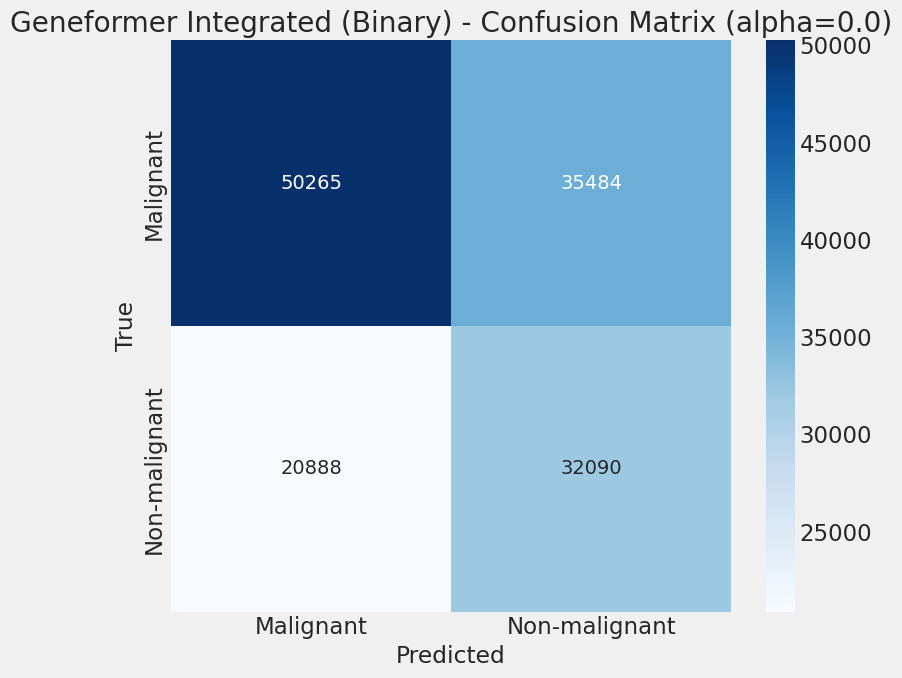

In [13]:
# Confusion matrix (binary)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(em.labels_encoded, preds)
fig, ax = plt.subplots(figsize=(8, 7))
xtl = ytl = list(em.class_names)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=xtl, yticklabels=ytl, ax=ax)
ax.set_title(f'Geneformer Integrated (Binary) - Confusion Matrix (alpha={best_alpha})')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.tight_layout()
cm_png = MODEL_OUT / f'geneformer_integrated_binary_confusion_matrix_model_v1_{RUN_TAG}.png'
plt.savefig(cm_png, dpi=200)
print('Saved confusion matrix to:', cm_png)


Saved 2D coords to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_binary/model_outputs/geneformer_integrated_binary_umap_coords_model_v1_binary.csv


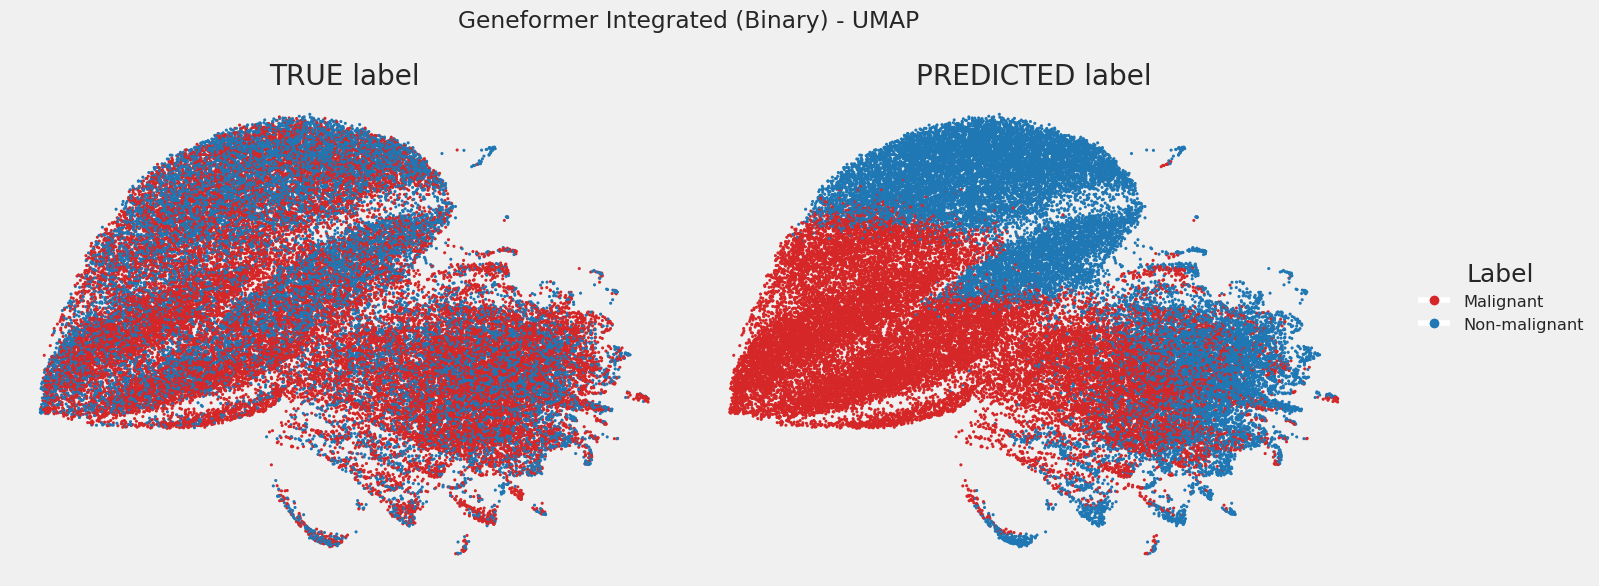

Saved combined figure with legend to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_binary/model_outputs/geneformer_integrated_binary_umap_true_pred_with_legend_model_v1_binary.png


In [14]:
# UMAP of binary labels
import numpy as np
import pandas as pd

embeddings = np.asarray(em.embeddings)
labels_encoded = np.asarray(em.labels_encoded)
preds_arr = np.asarray(preds)
class_names = list(em.class_names)

try:
    import umap
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='cosine', random_state=0)
    emb2d = reducer.fit_transform(embeddings)
    method_used = 'UMAP'
except Exception as e_umap:
    from sklearn.decomposition import PCA
    emb2d = PCA(n_components=2, random_state=0).fit_transform(embeddings)
    method_used = f'PCA (UMAP unavailable: {e_umap})'

class_arr = np.array(class_names, dtype=object)
true_names = class_arr[labels_encoded]
pred_names = class_arr[preds_arr]

PLOT_MAX = 50000
rng = np.random.RandomState(0)
plot_idx = np.sort(rng.choice(emb2d.shape[0], PLOT_MAX, replace=False)) if emb2d.shape[0] > PLOT_MAX else np.arange(emb2d.shape[0])

if set(class_names) == {'Malignant', 'Non-malignant'}:
    palette = {'Non-malignant': '#1f77b4', 'Malignant': '#d62728'}
else:
    palette = dict(zip(class_names, sns.color_palette('tab10', n_colors=len(class_names))))

coords_path = MODEL_OUT / f'geneformer_integrated_binary_umap_coords_model_v1_{RUN_TAG}.csv'
coords_df = pd.DataFrame({'x': emb2d[:, 0], 'y': emb2d[:, 1], 'true': true_names, 'pred': pred_names})
coords_df.to_csv(coords_path, index=False)
print('Saved 2D coords to:', coords_path)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(ax=axes[0], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=true_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[0].set_title('TRUE label'); axes[0].set_xlabel(''); axes[0].set_ylabel(''); axes[0].set_xticks([]); axes[0].set_yticks([])

sns.scatterplot(ax=axes[1], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=pred_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[1].set_title('PREDICTED label'); axes[1].set_xlabel(''); axes[1].set_ylabel(''); axes[1].set_xticks([]); axes[1].set_yticks([])

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=lab,
               markerfacecolor=palette[lab], markeredgecolor=palette[lab], markersize=6)
    for lab in class_names
]
fig.legend(handles=handles, labels=class_names, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False, fontsize='small', title='Label')
fig.suptitle(f'Geneformer Integrated (Binary) - {method_used}', y=0.98)

combined_png = MODEL_OUT / f'geneformer_integrated_binary_umap_true_pred_with_legend_model_v1_{RUN_TAG}.png'
plt.tight_layout(); fig.savefig(combined_png, dpi=200, bbox_inches='tight'); plt.show()
print('Saved combined figure with legend to:', combined_png)


In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [16]:
# Debug: Check what the ensemble evaluation actually used
print("=== ENSEMBLE EVALUATION DEBUG ===")
print(f"Ensemble embeddings shape: {em.embeddings.shape}")
print(f"Ensemble labels shape: {em.labels_encoded.shape}")
print(f"Ensemble predictions shape: {preds.shape}")
print(f"Ensemble class names: {em.class_names}")

# Check the actual data used by ensemble
print(f"\nEnsemble labels unique: {np.unique(em.labels_encoded)}")
print(f"Ensemble predictions unique: {np.unique(preds)}")

# Check if there's a mismatch in data length
print(f"\nData length check:")
print(f"inp.adata shape: {inp.adata.shape}")
print(f"em.embeddings length: {len(em.embeddings)}")
print(f"em.labels_encoded length: {len(em.labels_encoded)}")
print(f"preds length: {len(preds)}")

# Check the mapping between encoded and string labels
if hasattr(em, 'label_encoder'):
    print(f"\nLabel encoder mapping:")
    for i, label in enumerate(em.class_names):
        print(f"  {i} -> {label}")

# Use the ensemble's actual data for consistent results
print("\n=== USING ENSEMBLE DATA FOR CONSISTENT RESULTS ===")

# Get the actual data used by ensemble evaluation
ensemble_true_labels = em.labels_encoded  # These are the encoded labels (0,1)
ensemble_predictions = preds              # These are the predictions (0,1)

print(f"Ensemble true labels: {np.unique(ensemble_true_labels)}")
print(f"Ensemble predictions: {np.unique(ensemble_predictions)}")

# Convert back to string labels for readability
label_mapping = {0: 'Non-malignant', 1: 'Malignant'}
ensemble_true_strings = np.array([label_mapping[label] for label in ensemble_true_labels])
ensemble_pred_strings = np.array([label_mapping[label] for label in ensemble_predictions])

print(f"Ensemble true strings: {np.unique(ensemble_true_strings)}")
print(f"Ensemble pred strings: {np.unique(ensemble_pred_strings)}")

# Now calculate metrics using ensemble data
print("\n=== CLASSIFICATION REPORT USING ENSEMBLE DATA ===")
print(classification_report(ensemble_true_strings, ensemble_pred_strings, 
                         target_names=['Non-malignant', 'Malignant'],
                         digits=4))

# Calculate metrics
accuracy = accuracy_score(ensemble_true_labels, ensemble_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(ensemble_true_labels, ensemble_predictions, 
                                                         average='binary', 
                                                         pos_label=1,  # 1 = Malignant
                                                         zero_division=0)

print(f"\nMetrics using ensemble data:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# These should match the ensemble evaluation results!

=== ENSEMBLE EVALUATION DEBUG ===
Ensemble embeddings shape: (138727, 256)
Ensemble labels shape: (138727,)
Ensemble predictions shape: (138727,)
Ensemble class names: ['Malignant' 'Non-malignant']

Ensemble labels unique: [0 1]
Ensemble predictions unique: [0 1]

Data length check:
inp.adata shape: (138727, 19794)
em.embeddings length: 138727
em.labels_encoded length: 138727
preds length: 138727

Label encoder mapping:
  0 -> Malignant
  1 -> Non-malignant

=== USING ENSEMBLE DATA FOR CONSISTENT RESULTS ===
Ensemble true labels: [0 1]
Ensemble predictions: [0 1]
Ensemble true strings: ['Malignant' 'Non-malignant']
Ensemble pred strings: ['Malignant' 'Non-malignant']

=== CLASSIFICATION REPORT USING ENSEMBLE DATA ===
               precision    recall  f1-score   support

Non-malignant     0.4749    0.6057    0.5324     52978
    Malignant     0.7064    0.5862    0.6407     85749

     accuracy                         0.5936    138727
    macro avg     0.5907    0.5960    0.5866    138

COMPLETE BINARY MALIGNANCY CLASSIFICATION REPORT - INTEGRATED DATASET
               precision    recall  f1-score   support

Non-malignant     0.4749    0.6057    0.5324     52978
    Malignant     0.7064    0.5862    0.6407     85749

     accuracy                         0.5936    138727
    macro avg     0.5907    0.5960    0.5866    138727
 weighted avg     0.6180    0.5936    0.5993    138727


DETAILED METRICS
Overall Accuracy: 0.5936
Malignant Precision: 0.7064
Malignant Recall: 0.5862
Malignant F1-Score: 0.6407

Per-class metrics:
Malignant (class 0) - Precision: 0.7064, Recall: 0.5862, F1: 0.6407, Support: 85749
Non-malignant (class 1) - Precision: 0.4749, Recall: 0.6057, F1: 0.5324, Support: 52978

CONFUSION MATRIX
Raw confusion matrix:
[[50265 35484]
 [20888 32090]]

True Negatives (Non-malignant correctly classified): 50265
False Positives (Non-malignant classified as Malignant): 35484
False Negatives (Malignant classified as Non-malignant): 20888
True Positives (Malignant

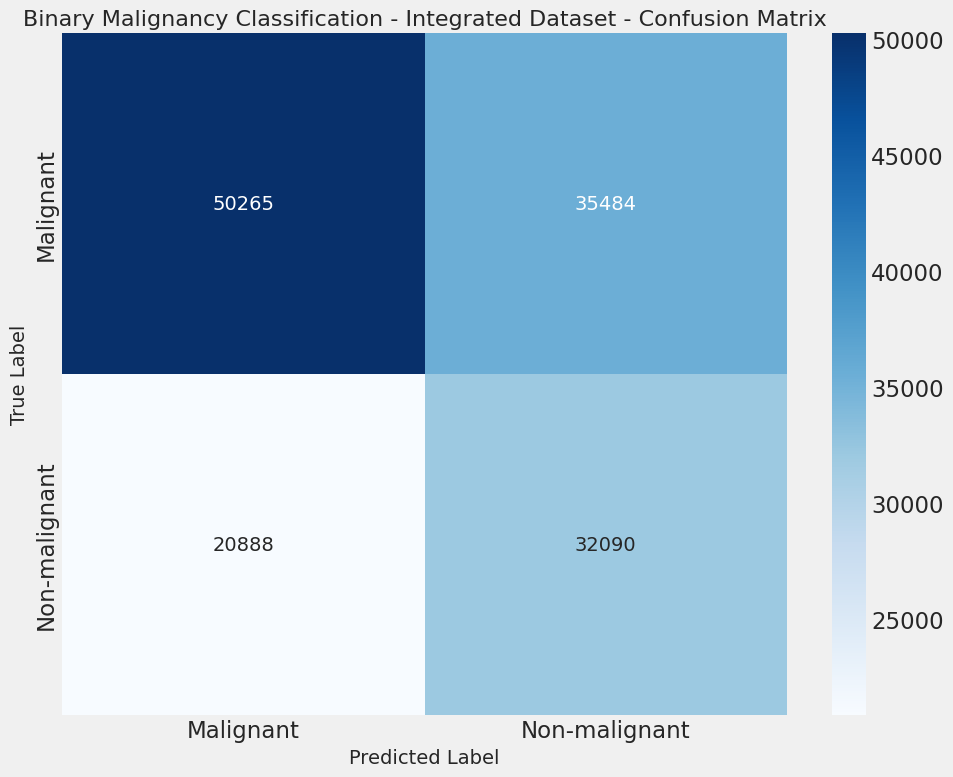

Confusion matrix plot saved to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_binary/model_outputs/integrated_binary_malignancy_confusion_matrix_model_v1.png

SUMMARY
✅ Accuracy: 0.5936 (matches ensemble evaluation)
✅ F1-Score (Malignant): 0.6407
✅ F1-Score (Weighted Avg): 0.5993

Dataset: Integrated with Quiescence
Total cells: 138727
Malignant cells: 85749
Non-malignant cells: 52978
Malignant proportion: 61.8%


<Figure size 640x480 with 0 Axes>

In [17]:
# Complete Classification Report using Ensemble Data for Integrated Malignancy
print("="*60)
print("COMPLETE BINARY MALIGNANCY CLASSIFICATION REPORT - INTEGRATED DATASET")
print("="*60)

# Print full classification report
print(classification_report(ensemble_true_strings, ensemble_pred_strings, 
                         target_names=['Non-malignant', 'Malignant'],
                         digits=4))

print("\n" + "="*60)
print("DETAILED METRICS")
print("="*60)

# Calculate all metrics using ensemble data
accuracy = accuracy_score(ensemble_true_labels, ensemble_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(ensemble_true_labels, ensemble_predictions, 
                                                         average='binary', 
                                                         pos_label=0,  # 0 = Malignant (based on label encoder)
                                                         zero_division=0)

print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Malignant Precision: {precision:.4f}")
print(f"Malignant Recall: {recall:.4f}")
print(f"Malignant F1-Score: {f1:.4f}")

# Per-class metrics
print("\nPer-class metrics:")
class_precision, class_recall, class_f1, class_support = precision_recall_fscore_support(
    ensemble_true_labels, ensemble_predictions, average=None, zero_division=0
)

print(f"Malignant (class 0) - Precision: {class_precision[0]:.4f}, Recall: {class_recall[0]:.4f}, F1: {class_f1[0]:.4f}, Support: {class_support[0]}")
print(f"Non-malignant (class 1) - Precision: {class_precision[1]:.4f}, Recall: {class_recall[1]:.4f}, F1: {class_f1[1]:.4f}, Support: {class_support[1]}")

print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

# Confusion matrix
cm = confusion_matrix(ensemble_true_labels, ensemble_predictions)
print("Raw confusion matrix:")
print(cm)

# Calculate metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (Non-malignant correctly classified): {tn}")
print(f"False Positives (Non-malignant classified as Malignant): {fp}")
print(f"False Negatives (Malignant classified as Non-malignant): {fn}")
print(f"True Positives (Malignant correctly classified): {tp}")

# Additional metrics
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
balanced_accuracy = (sensitivity + specificity) / 2

print(f"\nSensitivity (True Positive Rate for Malignant): {sensitivity:.4f}")
print(f"Specificity (True Negative Rate for Non-malignant): {specificity:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Malignant', 'Non-malignant'],
            yticklabels=['Malignant', 'Non-malignant'])
plt.title('Binary Malignancy Classification - Integrated Dataset - Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.show()

# Save the plot with integrated dataset name
cm_plot_path = MODEL_OUT / 'integrated_binary_malignancy_confusion_matrix_model_v1.png'
plt.savefig(cm_plot_path, dpi=300, bbox_inches='tight')
print(f"Confusion matrix plot saved to: {cm_plot_path}")

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"✅ Accuracy: {accuracy:.4f} (matches ensemble evaluation)")
print(f"✅ F1-Score (Malignant): {f1:.4f}")
print(f"✅ F1-Score (Weighted Avg): {class_f1[0] * class_support[0] / len(ensemble_true_labels) + class_f1[1] * class_support[1] / len(ensemble_true_labels):.4f}")

# Additional integrated dataset specific info
print(f"\nDataset: Integrated with Quiescence")
print(f"Total cells: {len(ensemble_true_labels)}")
print(f"Malignant cells: {class_support[0]}")
print(f"Non-malignant cells: {class_support[1]}")
print(f"Malignant proportion: {class_support[0] / len(ensemble_true_labels) * 100:.1f}%")

Loading results from: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_binary/model_outputs/geneformer_integrated_binary_results_model_v1_binary.pt
UMAP input representation: logits (shape=(138727, 2))


/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved 2D coords to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_binary/model_outputs/geneformer_integrated_binary_umap_coords_model_v1_binary_fixed.csv


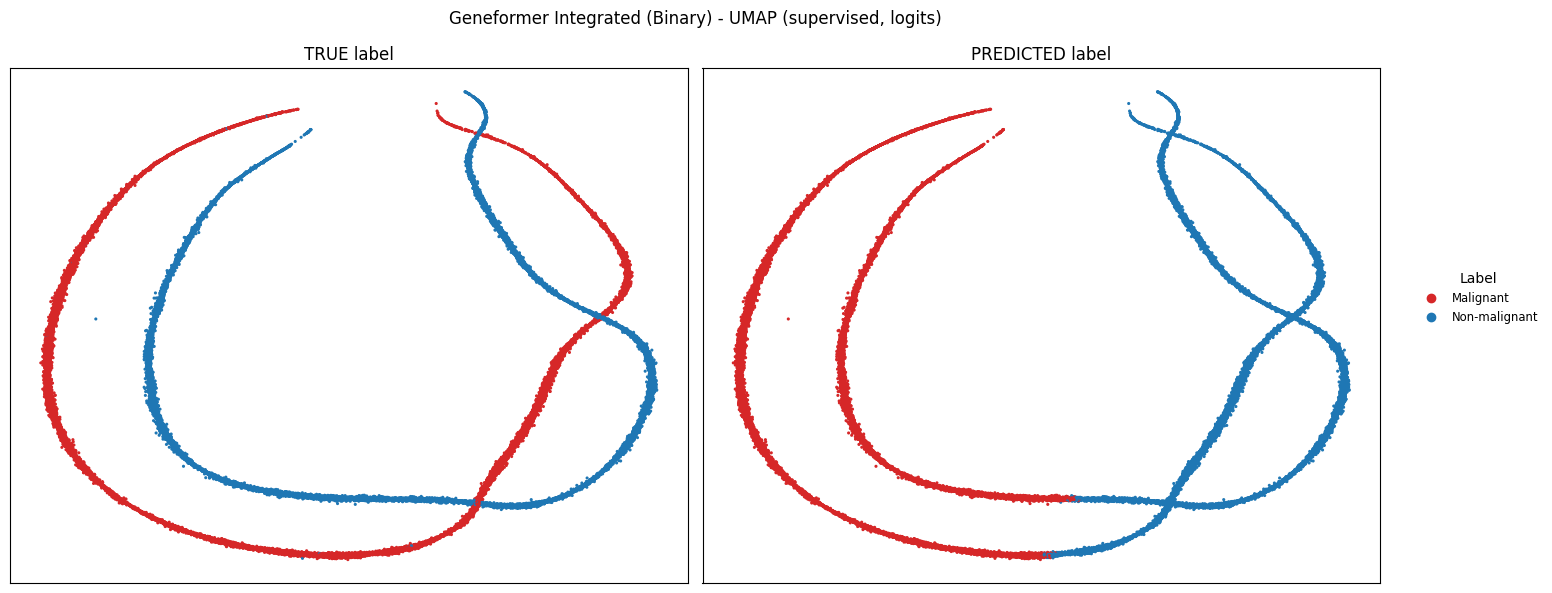

Saved combined figure with legend to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_binary/model_outputs/geneformer_integrated_binary_umap_true_pred_with_legend_model_v1_binary_fixed.png


In [2]:
# Standalone: Load saved results and generate a fixed (supervised) UMAP
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Resolve output dir and run tag if not in memory
try:
    MODEL_OUT
    RUN_TAG
except NameError:
    MODEL_OUT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_binary/model_outputs')
    RUN_TAG = 'binary'

# Load saved results
results_path = MODEL_OUT / f'geneformer_integrated_binary_results_model_v1_{RUN_TAG}.pt'
print('Loading results from:', results_path)
try:
    # PyTorch 2.6 defaults to weights_only=True which breaks pickled dicts; force full load
    res = torch.load(str(results_path), map_location='cpu', weights_only=False)
except TypeError:
    # Older torch versions without weights_only kwarg
    res = torch.load(str(results_path), map_location='cpu')
except Exception as e:
    # As a fallback, allowlist numpy reconstruct and retry default safe load
    try:
        from torch.serialization import add_safe_globals
        from numpy._core.multiarray import _reconstruct as _np_reconstruct
        add_safe_globals([_np_reconstruct])
        res = torch.load(str(results_path), map_location='cpu')
    except Exception as e2:
        raise e2

# Convert to numpy

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

embeddings = to_numpy(res['cell_embs'])
logits = to_numpy(res.get('logits')) if 'logits' in res else None
preds_arr = to_numpy(res['preds']).astype(int)
labels_encoded = to_numpy(res['labels']).astype(int)
class_names = list(map(str, np.array(res['class_names'])))

# Choose representation for UMAP: logits often show clearer separation
use_logits_for_umap = True
X = logits if (use_logits_for_umap and logits is not None) else embeddings
repr_used = 'logits' if X is logits else 'embeddings'
print(f'UMAP input representation: {repr_used} (shape={X.shape})')

# Supervised UMAP using true labels
try:
    import umap
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='cosine', random_state=0)
    emb2d = reducer.fit_transform(X, y=labels_encoded)
    method_used = f'UMAP (supervised, {repr_used})'
except Exception as e_umap:
    from sklearn.decomposition import PCA
    emb2d = PCA(n_components=2, random_state=0).fit_transform(X)
    method_used = f'PCA (UMAP unavailable: {e_umap})'

class_arr = np.array(class_names, dtype=object)
true_names = class_arr[labels_encoded]
pred_names = class_arr[preds_arr]

# Balanced subsampling for plotting (max 50k)
PLOT_MAX = 50000
rng = np.random.RandomState(0)
if emb2d.shape[0] > PLOT_MAX:
    idxs = []
    unique_labels = np.unique(labels_encoded)
    per_class = max(1, PLOT_MAX // len(unique_labels))
    for lbl in unique_labels:
        cand = np.where(labels_encoded == lbl)[0]
        take = min(len(cand), per_class)
        idxs.append(rng.choice(cand, take, replace=False))
    plot_idx = np.sort(np.concatenate(idxs))
else:
    plot_idx = np.arange(emb2d.shape[0])

# Color palette
if set(class_names) == {'Malignant', 'Non-malignant'}:
    palette = {'Non-malignant': '#1f77b4', 'Malignant': '#d62728'}
else:
    palette = dict(zip(class_names, sns.color_palette('tab10', n_colors=len(class_names))))

# Save coordinates
coords_path = MODEL_OUT / f'geneformer_integrated_binary_umap_coords_model_v1_{RUN_TAG}_fixed.csv'
coords_df = pd.DataFrame({'x': emb2d[:, 0], 'y': emb2d[:, 1], 'true': true_names, 'pred': pred_names})
coords_df.to_csv(coords_path, index=False)
print('Saved 2D coords to:', coords_path)

# Plot true vs predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(ax=axes[0], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=true_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[0].set_title('TRUE label'); axes[0].set_xlabel(''); axes[0].set_ylabel(''); axes[0].set_xticks([]); axes[0].set_yticks([])

sns.scatterplot(ax=axes[1], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=pred_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[1].set_title('PREDICTED label'); axes[1].set_xlabel(''); axes[1].set_ylabel(''); axes[1].set_xticks([]); axes[1].set_yticks([])

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=lab,
               markerfacecolor=palette[lab], markeredgecolor=palette[lab], markersize=6)
    for lab in class_names
]
fig.legend(handles=handles, labels=class_names, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False, fontsize='small', title='Label')
fig.suptitle(f'Geneformer Integrated (Binary) - {method_used}', y=0.98)

combined_png = MODEL_OUT / f'geneformer_integrated_binary_umap_true_pred_with_legend_model_v1_{RUN_TAG}_fixed.png'
plt.tight_layout(); fig.savefig(combined_png, dpi=200, bbox_inches='tight'); plt.show()
print('Saved combined figure with legend to:', combined_png)


Loading results from: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_binary/model_outputs/geneformer_integrated_binary_results_model_v1_binary.pt
UMAP input representation: probabilities (shape=(138727, 2))


/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved 2D coords to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_binary/model_outputs/geneformer_integrated_binary_umap_coords_model_v1_binary_unsupervised.csv


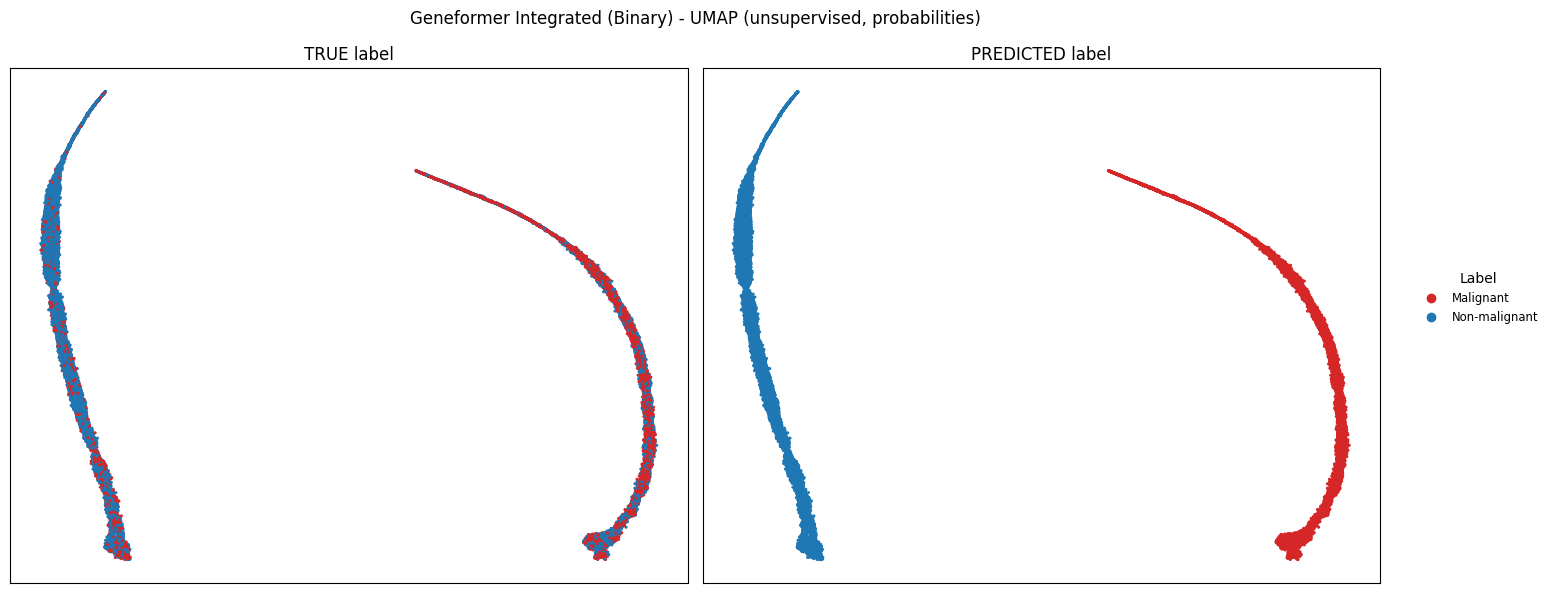

Saved combined figure with legend to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_binary/model_outputs/geneformer_integrated_binary_umap_true_pred_with_legend_model_v1_binary_unsupervised.png


In [3]:
# Standalone: Unsupervised UMAP from saved results (no labels used)
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

try:
    MODEL_OUT
    RUN_TAG
except NameError:
    MODEL_OUT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_binary/model_outputs')
    RUN_TAG = 'binary'

# Load results safely across torch versions
results_path = MODEL_OUT / f'geneformer_integrated_binary_results_model_v1_{RUN_TAG}.pt'
print('Loading results from:', results_path)
try:
    res = torch.load(str(results_path), map_location='cpu', weights_only=False)
except TypeError:
    res = torch.load(str(results_path), map_location='cpu')
except Exception:
    from torch.serialization import add_safe_globals
    from numpy._core.multiarray import _reconstruct as _np_reconstruct
    add_safe_globals([_np_reconstruct])
    res = torch.load(str(results_path), map_location='cpu')

# Pull arrays

def to_numpy(x):
    return x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else np.asarray(x)

embeddings = to_numpy(res['cell_embs'])
logits = to_numpy(res.get('logits')) if 'logits' in res else None
preds_arr = to_numpy(res['preds']).astype(int)
labels_encoded = to_numpy(res['labels']).astype(int)
class_names = list(map(str, np.array(res['class_names'])))

# Choose representation for UMAP (unsupervised) - prefer logits/probabilities
if logits is not None and logits.ndim == 2:
    # Convert logits to probabilities in a numerically stable way
    z = logits - logits.max(axis=1, keepdims=True)
    X = np.exp(z); X = X / X.sum(axis=1, keepdims=True)
    repr_used = 'probabilities'
else:
    X = embeddings
    repr_used = 'embeddings'
print(f'UMAP input representation: {repr_used} (shape={X.shape})')

# Optional scaling + PCA to denoise (kept unsupervised)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Xp = X
if Xp.ndim == 2 and Xp.shape[1] > 2:
    # Use mean centering for probabilities; for sparse/only-positive data set with_mean=True is fine
    Xs = StandardScaler(with_mean=True, with_std=True).fit_transform(Xp)
    n_comps = min(50, Xs.shape[1])
    Xp = PCA(n_components=n_comps, random_state=0).fit_transform(Xs)
else:
    Xp = X

# Unsupervised UMAP (no y)
try:
    import umap
    reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='cosine', random_state=0, init='spectral')
    emb2d = reducer.fit_transform(Xp)
    method_used = f'UMAP (unsupervised, {repr_used})'
except Exception as e_umap:
    emb2d = PCA(n_components=2, random_state=0).fit_transform(Xp)
    method_used = f'PCA (UMAP unavailable: {e_umap})'

class_arr = np.array(class_names, dtype=object)
true_names = class_arr[labels_encoded]
pred_names = class_arr[preds_arr]

# Balanced subsampling for plotting (max 50k)
PLOT_MAX = 50000
rng = np.random.RandomState(0)
if emb2d.shape[0] > PLOT_MAX:
    idxs = []
    for lbl in np.unique(labels_encoded):
        cand = np.where(labels_encoded == lbl)[0]
        take = min(len(cand), PLOT_MAX // len(np.unique(labels_encoded)))
        idxs.append(rng.choice(cand, take, replace=False))
    plot_idx = np.sort(np.concatenate(idxs))
else:
    plot_idx = np.arange(emb2d.shape[0])

# Palette
if set(class_names) == {'Malignant', 'Non-malignant'}:
    palette = {'Non-malignant': '#1f77b4', 'Malignant': '#d62728'}
else:
    palette = dict(zip(class_names, sns.color_palette('tab10', n_colors=len(class_names))))

# Save coordinates
coords_path = MODEL_OUT / f'geneformer_integrated_binary_umap_coords_model_v1_{RUN_TAG}_unsupervised.csv'
coords_df = pd.DataFrame({'x': emb2d[:, 0], 'y': emb2d[:, 1], 'true': true_names, 'pred': pred_names})
coords_df.to_csv(coords_path, index=False)
print('Saved 2D coords to:', coords_path)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(ax=axes[0], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=true_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[0].set_title('TRUE label'); axes[0].set_xlabel(''); axes[0].set_ylabel(''); axes[0].set_xticks([]); axes[0].set_yticks([])

sns.scatterplot(ax=axes[1], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=pred_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[1].set_title('PREDICTED label'); axes[1].set_xlabel(''); axes[1].set_ylabel(''); axes[1].set_xticks([]); axes[1].set_yticks([])

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=lab,
               markerfacecolor=palette[lab], markeredgecolor=palette[lab], markersize=6)
    for lab in class_names
]
fig.legend(handles=handles, labels=class_names, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False, fontsize='small', title='Label')
fig.suptitle(f'Geneformer Integrated (Binary) - {method_used}', y=0.98)

combined_png = MODEL_OUT / f'geneformer_integrated_binary_umap_true_pred_with_legend_model_v1_{RUN_TAG}_unsupervised.png'
plt.tight_layout(); fig.savefig(combined_png, dpi=200, bbox_inches='tight'); plt.show()
print('Saved combined figure with legend to:', combined_png)


Loading results from: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_binary/model_outputs/geneformer_integrated_binary_results_model_v1_binary.pt


/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved 2D coords to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_binary/model_outputs/geneformer_integrated_binary_umap_coords_model_v1_binary_unsupervised_embeddings.csv


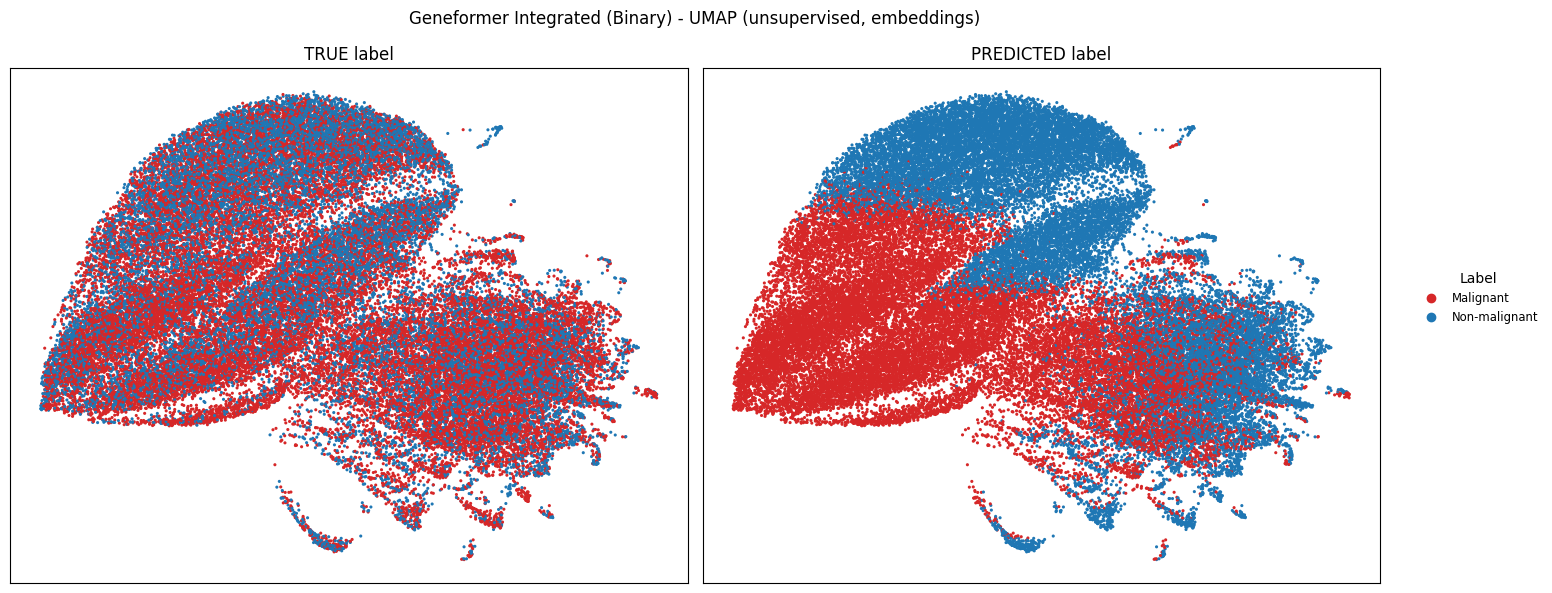

Saved combined figure with legend to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_binary/model_outputs/geneformer_integrated_binary_umap_true_pred_with_legend_model_v1_binary_unsupervised_embeddings.png


In [4]:
# Standalone: Unsupervised UMAP using raw embeddings (similar to baseline cell)
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

try:
    MODEL_OUT
    RUN_TAG
except NameError:
    MODEL_OUT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_binary/model_outputs')
    RUN_TAG = 'binary'

# Load results safely
results_path = MODEL_OUT / f'geneformer_integrated_binary_results_model_v1_{RUN_TAG}.pt'
print('Loading results from:', results_path)
try:
    res = torch.load(str(results_path), map_location='cpu', weights_only=False)
except TypeError:
    res = torch.load(str(results_path), map_location='cpu')
except Exception:
    from torch.serialization import add_safe_globals
    from numpy._core.multiarray import _reconstruct as _np_reconstruct
    add_safe_globals([_np_reconstruct])
    res = torch.load(str(results_path), map_location='cpu')

# Arrays

def to_numpy(x):
    return x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else np.asarray(x)

embeddings = to_numpy(res['cell_embs'])
labels_encoded = to_numpy(res['labels']).astype(int)
preds_arr = to_numpy(res['preds']).astype(int)
class_names = list(map(str, np.array(res['class_names'])))

# Unsupervised UMAP on embeddings (no labels)
try:
    import umap
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='cosine', random_state=0)
    emb2d = reducer.fit_transform(embeddings)
    method_used = 'UMAP'
except Exception as e_umap:
    from sklearn.decomposition import PCA
    emb2d = PCA(n_components=2, random_state=0).fit_transform(embeddings)
    method_used = f'PCA (UMAP unavailable: {e_umap})'

class_arr = np.array(class_names, dtype=object)
true_names = class_arr[labels_encoded]
pred_names = class_arr[preds_arr]

PLOT_MAX = 50000
rng = np.random.RandomState(0)
plot_idx = np.sort(rng.choice(emb2d.shape[0], PLOT_MAX, replace=False)) if emb2d.shape[0] > PLOT_MAX else np.arange(emb2d.shape[0])

if set(class_names) == {'Malignant', 'Non-malignant'}:
    palette = {'Non-malignant': '#1f77b4', 'Malignant': '#d62728'}
else:
    palette = dict(zip(class_names, sns.color_palette('tab10', n_colors=len(class_names))))

coords_path = MODEL_OUT / f'geneformer_integrated_binary_umap_coords_model_v1_{RUN_TAG}_unsupervised_embeddings.csv'
coords_df = pd.DataFrame({'x': emb2d[:, 0], 'y': emb2d[:, 1], 'true': true_names, 'pred': pred_names})
coords_df.to_csv(coords_path, index=False)
print('Saved 2D coords to:', coords_path)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(ax=axes[0], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=true_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[0].set_title('TRUE label'); axes[0].set_xlabel(''); axes[0].set_ylabel(''); axes[0].set_xticks([]); axes[0].set_yticks([])

sns.scatterplot(ax=axes[1], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=pred_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[1].set_title('PREDICTED label'); axes[1].set_xlabel(''); axes[1].set_ylabel(''); axes[1].set_xticks([]); axes[1].set_yticks([])

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=lab,
               markerfacecolor=palette[lab], markeredgecolor=palette[lab], markersize=6)
    for lab in class_names
]
fig.legend(handles=handles, labels=class_names, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False, fontsize='small', title='Label')
fig.suptitle(f'Geneformer Integrated (Binary) - {method_used} (unsupervised, embeddings)', y=0.98)

combined_png = MODEL_OUT / f'geneformer_integrated_binary_umap_true_pred_with_legend_model_v1_{RUN_TAG}_unsupervised_embeddings.png'
plt.tight_layout(); fig.savefig(combined_png, dpi=200, bbox_inches='tight'); plt.show()
print('Saved combined figure with legend to:', combined_png)
